In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = web.DataReader('AMZN', data_source='yahoo', start='2010-01-01', end='2023-05-12') 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000
2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004
...,...,...,...,...,...,...
2022-05-10,2252.850098,2143.419922,2225.000000,2177.179932,5271700,2177.179932
2022-05-11,2203.120117,2088.570068,2162.070068,2107.439941,5485200,2107.439941
2022-05-12,2215.610107,2048.110107,2055.000000,2138.610107,6601300,2138.610107


In [3]:
df.shape

(3114, 6)

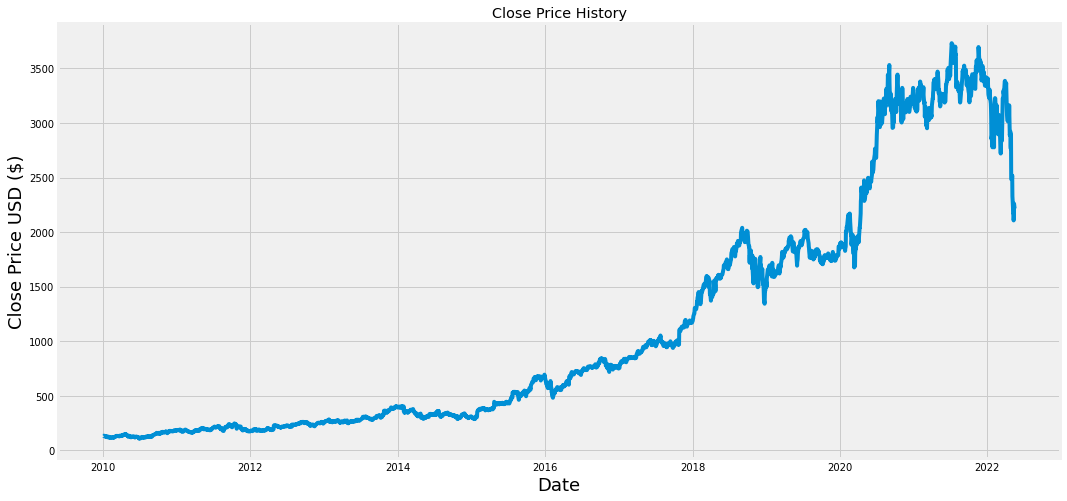

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
train_data = scaled_data[0:training_data_len  , : ]
x_train=([])
y_train = ([])
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [8]:
x_train, y_train = np.array(x_train),np.array(y_train)

In [9]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

2022-05-16 19:38:19.344166: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(x_train, y_train, batch_size=1, epochs=7)

Epoch 1/7
2432/2432 [==============================] - 48s 18ms/step - loss: 4.5303e-04
Epoch 2/7
2432/2432 [==============================] - 41s 17ms/step - loss: 2.2027e-04
Epoch 3/7
2432/2432 [==============================] - 44s 18ms/step - loss: 1.7276e-04
Epoch 4/7
2432/2432 [==============================] - 45s 19ms/step - loss: 9.8949e-05
Epoch 5/7
2432/2432 [==============================] - 47s 19ms/step - loss: 1.0398e-04
Epoch 6/7
2432/2432 [==============================] - 45s 18ms/step - loss: 1.0377e-04
Epoch 7/7
2432/2432 [==============================] - 48s 20ms/step - loss: 9.6857e-05


In [13]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [14]:
x_test = np.array(x_test)

In [15]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [16]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [17]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

73.48176835452237

/var/folders/nc/cnlrtvy52f70c1k57c4nmdhm0000gn/T/ipykernel_54883/1882800951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


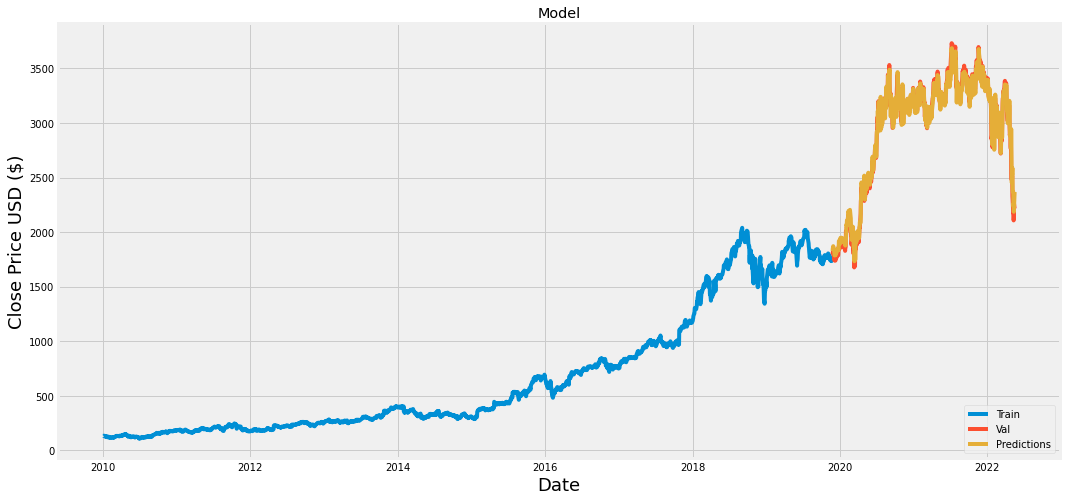

In [18]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
valid

,Close,Predictions
Date,,
2019-11-26,1796.939941,1827.138672
2019-11-27,1818.510010,1850.304199
2019-11-29,1800.800049,1871.555298
2019-12-02,1781.599976,1850.574951
2019-12-03,1769.959961,1829.332275
...,...,...
2022-05-10,2177.179932,2238.107666
2022-05-11,2107.439941,2261.493408
2022-05-12,2138.610107,2186.645996
